Scatter plot of a run (True vs Predicted values) for Random Forest Regression Model

The Scatter Plot is estimated for data with and without imbued 0s, and for three different set of bins and before and after ReducedOverfitting. It also plots for data where the damaged values (target) are greater than 10.

In [2]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib


wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")
#display(combined_input_data)

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 
#display(combined_input_data)
#combined_input_data.hist(column="DAM_perc_dmg") 

combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

features =['HAZ_rainfall_Total', 
           'HAZ_rainfall_max_6h',
           'HAZ_rainfall_max_24h',
           'HAZ_v_max',
           'HAZ_v_max_3',
           'HAZ_dis_track_min',
           'GEN_landslide_per',
           'GEN_stormsurge_per',
           #'GEN_Bu_p_inSSA', 
           #'GEN_Bu_p_LS', 
           'GEN_Red_per_LSbldg',
           'GEN_Or_per_LSblg', 
           'GEN_Yel_per_LSSAb', 
           #'GEN_RED_per_SSAbldg',
           'GEN_OR_per_SSAbldg',
           'GEN_Yellow_per_LSbl',
           'TOP_mean_slope',
           'TOP_mean_elevation_m', 
           'TOP_ruggedness_stdev', 
           #'TOP_mean_ruggedness',
           #'TOP_slope_stdev', 
           'VUL_poverty_perc',
           'GEN_with_coast',
           'GEN_coast_length', 
           'VUL_Housing_Units',
           'VUL_StrongRoof_StrongWall', 
           'VUL_StrongRoof_LightWall',
           'VUL_StrongRoof_SalvageWall', 
           'VUL_LightRoof_StrongWall',
           'VUL_LightRoof_LightWall', 
           'VUL_LightRoof_SalvageWall',
           'VUL_SalvagedRoof_StrongWall',
           'VUL_SalvagedRoof_LightWall',
           'VUL_SalvagedRoof_SalvageWall', 
           'VUL_vulnerable_groups',
           'VUL_pantawid_pamilya_beneficiary']


df=combined_input_data.dropna()
display(df)



,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
2,durian2006,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.00,...,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000
4,durian2006,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,1.28,...,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000
6,durian2006,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,...,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000
7,durian2006,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.36,...,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,noul2015,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,6.25,...,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000
25837,noul2015,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,...,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000
25838,noul2015,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.09,...,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000
25839,noul2015,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,...,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000


In [3]:
#df = df[df['DAM_perc_dmg'] > 10]
#df

#Stratify sampling
all_0 = df['DAM_perc_dmg'].loc[df['DAM_perc_dmg'] == 0.0]
#display(all_0)

all_1 = df['DAM_perc_dmg'].loc[(0.0 < df['DAM_perc_dmg']) & (1.0 >= df['DAM_perc_dmg'])]
#display(all_1)

all_2 = df['DAM_perc_dmg'].loc[(1.0 < df['DAM_perc_dmg']) & (60.0 >= df['DAM_perc_dmg'])]
#display(all_2)

all_3 = df['DAM_perc_dmg'].loc[(60.0 < df['DAM_perc_dmg']) & (100.0 >= df['DAM_perc_dmg'])]
#display(all_3)

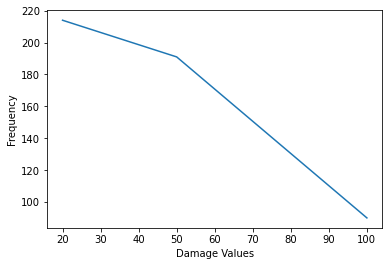

In [4]:
#The Old and New set of bins
#bins2= [0, 1, 60, 100]
#bins2 = [0, 0.00009, 1, 10, 50, 100]
bins2= [10.0009, 20, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [5]:
print(samples_per_bin2)
print(binsP2)

[214 191  90]
[ 10.0009  20.      50.     100.    ]


In [6]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [7]:
y_input_strat=bin_index2

In [8]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2) 


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

(6458, 31) (6458,)
(1615, 31) (1615,)


In [9]:
# create an Random Forest regression model
from sklearn.ensemble import RandomForestRegressor

#Without Solving Overfitting problem
#rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)

#With ReducedOverfitting
rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)

rf_model=rf.fit(X_train, y_train)

In [10]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     189.0
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        02:27:09   Log-Likelihood:                -21381.
No. Observations:                6458   AIC:                         4.283e+04
Df Residuals:                    6426   BIC:                         4.304e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4535      0.083     29.648      0.0

In [11]:
y_pred_train = rf.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mx_train = max_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).sum()/len(y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mx = max_error(y_test, y_pred)
me = (y_pred - y_test).sum()/len(y_test)

#df_pred=pd.DataFrame(columns = ['test', 'pred'])
#df_pred['pred'] = y_pred
#df_pred['test'] = y_test

print('----- Test  ------')
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Max error: {mx:.2f}')
print(f"Average Error: {me:.2f}")

print('---- Training -----')
print(f'Mean absolute error: {mae_train:.2f}')
print(f'Mean squared error: {mse_train:.2f}')
print(f'Root mean squared error: {rmse_train:.2f}')
print(f'Max error: {mx_train:.2f}')
print(f"Average Error: {me_train:.2f}")

----- Test  ------
Mean absolute error: 2.01
Mean squared error: 42.28
Root mean squared error: 6.50
Max error: 89.15
Average Error: 0.02
---- Training -----
Mean absolute error: 1.34
Mean squared error: 18.76
Root mean squared error: 4.33
Max error: 78.25
Average Error: 0.03


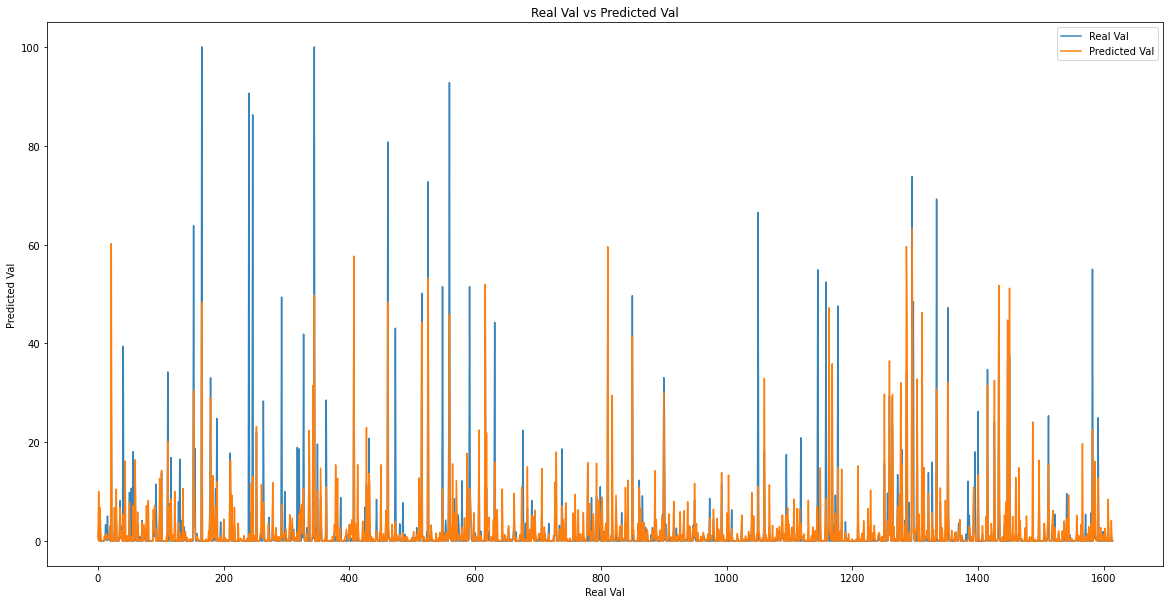

In [12]:
index = np.arange(0,len(y_test))
fig, ax = plt.subplots(1,1,figsize=(20,10))
plt.plot(index,y_test, label = 'Real Val', alpha=0.9)
plt.plot(index,y_pred, label = 'Predicted Val')
plt.title('Real Val vs Predicted Val')
plt.xlabel('Real Val')
plt.ylabel('Predicted Val')
plt.legend()

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Difference', fontsize=10)
plt.title('True vs Difference in Predicted damaged values')
plt.axis('equal')
plt.show()

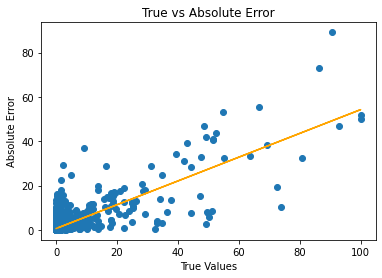

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = y_test
y = abs(y_pred - y_test)

plt.scatter(x, y, cmap='viridis')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='orange')


plt.xlabel('True Values', fontsize=10)
plt.ylabel('Absolute Error', fontsize=10)
plt.title('True vs Absolute Error')
plt.show()